#### Imports

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tkinter import *
from tkinter import filedialog
from scipy.signal import lfilter
from ipywidgets import interactive, widgets
from IPython.display import display

##### Functions and definitions

##### open chart image and adjust boundaries

In [93]:
raw_image = file_open_popup()
boundaries = interactive(boundary_selection_widgethelper, im = widgets.fixed(raw_image), 
                    x_start_crop = 
                        widgets.FloatSlider(value=10, min=0, max=25, step=0.01, layout=widgets.Layout(width='50%')),
                    y_start_crop =  
                        widgets.FloatSlider(value=10, min=0, max=25, step=0.1, layout=widgets.Layout(width='50%')),
                    x_end_crop = 
                        widgets.FloatSlider(value=10, min=0, max=25, step=0.1, layout=widgets.Layout(width='50%')),
                    y_end_crop =  
                        widgets.FloatSlider(value=10, min=0, max=25, step=0.1, layout=widgets.Layout(width='50%')))
# print('boundary data is saved in real time, after adjusting, no extra action is needed, just go to the next section')
display (boundaries)

boundary data is saved in real time, after adjusting, no extra action is needed, just go to the next section


interactive(children=(FloatSlider(value=10.0, description='x_start_crop', layout=Layout(width='50%'), max=25.0…

In [608]:
def file_open_popup():
    root = Tk()
    root.withdraw()
    root.wm_attributes('-topmost', 1)
    currdir = os.getcwd()
    path = filedialog.askopenfilename(parent=root, initialdir=currdir, title='Please select your chart')
    return cv2.imread(path)[::-1,:,::-1]

def boundary_selection_widgethelper(im, x_start_crop, y_start_crop, x_end_crop, y_end_crop):
    plt.figure(figsize=(8 * im.shape[1] / im.shape[0], 8))
    plt.imshow(im)
    plt.axhline(y_start_crop * im.shape[0] / 100, c='r', linewidth=0.7)
    plt.axhline((100 - y_end_crop) * im.shape[0] / 100, c='r', linewidth=0.7)
    plt.axvline(x_start_crop * im.shape[1] / 100, c='r', linewidth=0.7)
    plt.axvline((100 - x_end_crop) * im.shape[1] / 100, c='r', linewidth=0.7)
    plt.gca().invert_yaxis()

def crop_image(im, bounds):
    x_origin = int(bounds.children[0]._trait_values['value'] * im.shape[1] / 100)
    x_end =  int((100 - bounds.children[2]._trait_values['value']) * im.shape[1] / 100)
    y_origin = int(bounds.children[1]._trait_values['value'] * im.shape[0] / 100)
    y_end =  int((100 - bounds.children[3]._trait_values['value']) * im.shape[0] / 100)
    return im[y_origin:y_end, x_origin:x_end]

def find_contours(im, sensitivity):
    img_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    _, img_gray = cv2.threshold(img_gray, (sensitivity) * 255, 255, cv2.THRESH_BINARY_INV)
    contours, _  = cv2.findContours(img_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def draw_countours(im, to_draw , padding):
    redrawed = np.zeros_like(cv2.cvtColor(im, cv2.COLOR_BGR2GRAY))
    cv2.drawContours(redrawed, to_draw, -1, 255, 2)
    for i in range(redrawed.shape[0]):
        for j in range(redrawed.shape[1]):
            if i < im.shape[0] * padding or j < im.shape[1] * padding or i > im.shape[0] * 0.99 or j > im.shape[1] * (1 - padding):
                redrawed[i,j] = 0
    return redrawed

def digitize_data(imageData):
    res = np.asarray(np.where(imageData == 255))
    unqa, ID, counts = np.unique(res[1:], return_inverse = True, return_counts = True)
    out = np.row_stack((unqa , np.bincount(ID, res[0,:]) / counts))
    return out

def step_bin(data, im_shape, x_range, y_range, step_size):  
    xArr = data[0] / im_shape[1] * (x_range[1] - x_range[0])
    yArr = data[1] / im_shape[0] * (y_range[1] - y_range[0]) + y_range[0]
    xdat, Ids, counts = np.unique((xArr / step_size).astype(int), return_inverse = True, return_counts = True)    
    ydat = np.bincount(Ids, yArr) / counts
    out = np.array((xdat * step_size + x_range[0], ydat))
    return out

def smooth_data(data, windowSize):
    step_size = data[0,1] - data[0,0]
    windowSize = 1 if int(windowSize / step_size) < 1 else int(windowSize / step_size)
    ncYArr = lfilter([1.0 / windowSize] * windowSize, 1, data[1])[int(windowSize/2):]
    ncXArr = data[0][:-int(windowSize/2) if -int(windowSize/2) < 0 else data.shape[1]]
    out = np.array((ncXArr, ncYArr))
    return out
    
def im_show(im, fig_ratio):
    plt.figure(figsize=(6 * fig_ratio, 6))
    plt.imshow(im)
    plt.gca().invert_yaxis()
    plt.show()
    
def plot_data(cropped, redrawed, final_data, retouched_data):
    _, ax = plt.subplots(3, 1, figsize=(6 * cropped.shape[1] / cropped.shape[0], 21))
    ax[0].imshow(cropped)
    ax[0].invert_yaxis()
    ax[0].set_title('Cropping')
    ax[1].imshow(cv2.cvtColor(redrawed, cv2.COLOR_GRAY2RGB))
    ax[1].set_title('Isolation')
    ax[1].invert_yaxis()
    ax[2].set_title('Final result')
    ax[2].plot(final_data[0], final_data[1], linewidth=3, alpha=0.7, linestyle="-", c="r", label='raw extracted data') 
    ax[2].plot(retouched_data[0], retouched_data[1], linewidth=0.9, linestyle="-", c="black", label='smoothed data') 
    ax[2].legend(loc='best')
    plt.show()
    
def save_data(data, file_name, isCsv = False):
    df = pd.DataFrame (data.T)
    df.columns = ['x_axis', 'y_axis']
    if isCsv:
        df.to_csv(file_name + '.csv', index=False)
    else :
        df.to_excel(file_name + '.xlsx', index=False)


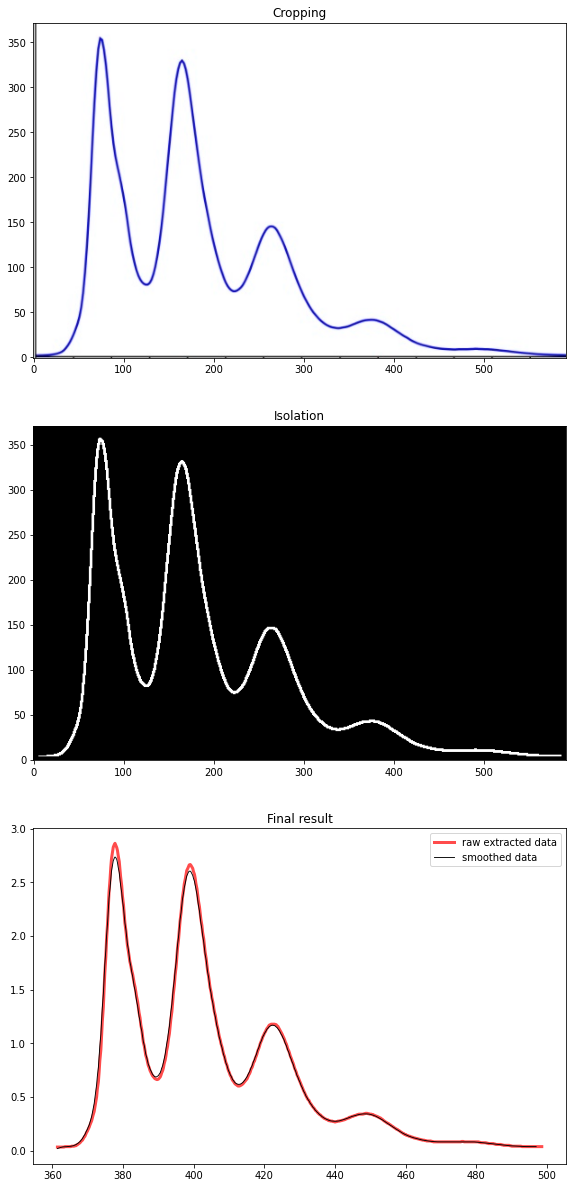

In [621]:
# boundaries
x_range = [360, 500]
y_range = [0, 3]
x_step_size = 0.1

# padding, detection sensitivity and smoothing factor
chart_padding = 0.01
sensitivity = 0.7
smoothing_factor = 3

cropped_image = crop_image(raw_image, bounds = boundaries)
contours = find_contours(cropped_image, sensitivity = sensitivity)
redrawed = draw_countours(cropped_image, to_draw = contours, padding = chart_padding)
digitized = digitize_data(redrawed)
final_data = step_bin(digitized, cropped_image.shape, x_range, y_range, x_step_size)
retouched_data = smooth_data(data = final_data, windowSize = smoothing_factor)
plot_data(cropped_image, redrawed, final_data, retouched_data)

In [622]:
file_name = 'chart_out'
data_to_save = final_data # you can save retouched_data if you want
save_data(data_to_save, file_name, isCsv = False)